In [1]:
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from math import *

import scipy as sp
import scipy.optimize

In [2]:
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection

def circles(x, y, s, c='b', **kwargs):
    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
        
    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    plt.draw_if_interactive()
    if c is not None:
        plt.sci(collection)
    return collection

0.008251190185546875 to generate 1000 population with 50 obsticles
0.19044804573059082 to simulate 1000 partitions with 50 obsticles


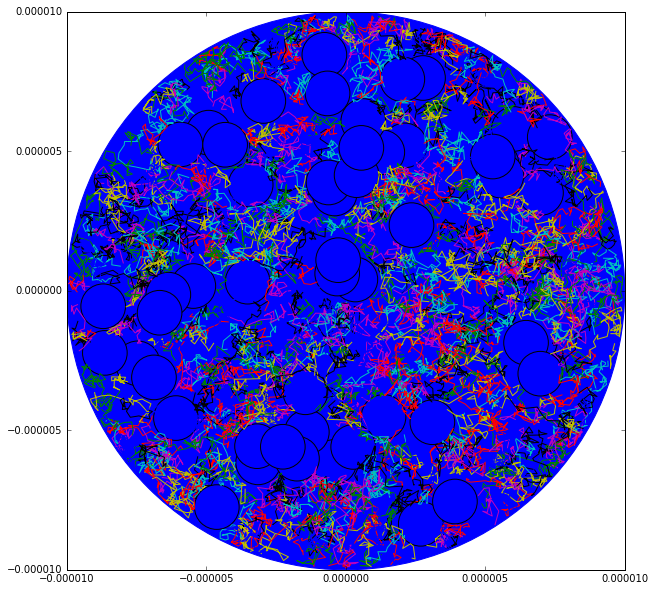

TypeError: generate_points() takes 3 positional arguments but 50 were given

In [45]:
def to_xyz(array):
    alpha, r, h = array
    return np.array([array[1] * np.cos(array[0]), array[1] * np.sin(array[0]), h])

def generate_parametrization(size, min_r, max_r):
    if not size:
        return np.zeros((size, 4))
    
    rs = np.random.uniform(min_r, max_r, [size, 1])

    alphas = np.random.uniform(0, np.pi * 2, [size, 1])
    ps = (R - rs)**2 * np.random.uniform(0, 1, [size, 1])
    hs = np.random.uniform(rs, H - rs, [size, 1])
    
    return np.hstack([ps, alphas, hs, rs])

def parametrization_to_coords(values):
    ps = np.sqrt(values[:, 0:1])
    xs = ps * np.cos(values[:, 1:2])
    ys = ps * np.sin(values[:, 1:2])
    
    return np.hstack([xs, ys, values[:, 2:]])

def generate_points(size, min_r, max_r):
    return parametrization_to_coords(generate_parametrization(size, min_r, max_r))

def generate_population(obsticles, population_size, min_r, max_r, min_prob=0):
    population = generate_points(population_size, min_r, max_r)
    bad = filter_collisions(population, obsticles)
    population = population[np.logical_not(bad)]
    prob = sum(np.logical_not(bad)) / len(bad)

    if prob < min_prob:
        return None, None
    
    while population.shape[0] < population_size:
        need = population_size - population.shape[0]
        estimated = ceil(1.1 * need / prob)
        
        beings = generate_points(estimated, min_r, max_r)
        bad = filter_collisions(beings, obsticles)
        beings = beings[np.logical_not(bad)]
        population = np.vstack([population, beings[:need]])
    
    return population, prob
        
def generate_population_obsticles(population_size, min_r, max_r, obsticles_count, o_min_r, o_max_r, min_prob=0):
    obsticles = generate_points(obsticles_count, o_min_r, o_max_r)
    population, _ = generate_population(obsticles, population_size, min_r, max_r, min_prob)
    return population, obsticles

def generate_displacement(population, delta_t):
    sigmas = np.sqrt(2 * preR / population[:, N] * delta_t)
    return np.random.randn(population.shape[0], population.shape[1] - 1) * sigmas[:, np.newaxis]

def check_for_out_of_bounds(population):
    first = population[:, N] <= population[:, N - 1]
    second = population[:, N - 1] <= H - population[:, N]
    third = np.linalg.norm(population[:, :N - 1], axis=1) <= R - population[:, N]
    
    return np.logical_not(np.logical_and(first, np.logical_and(second, third)))

def check_for_collisions_being(being, obsticles):
    return np.linalg.norm(obsticles[:, :N] - being[:N], axis=1) ** 2 < (obsticles[:, N] + being[N]) ** 2
    
def check_for_collisions_obsticle(obsticle, population):
    return np.linalg.norm(population[:, :N] - obsticle[:N], axis=1) ** 2 < (population[:, N] + obsticle[N]) ** 2

# def filter_collisions(population, obsticles):
#     return np.any(np.apply_along_axis(check_for_collisions, 1, population, obsticles), axis=1)

def filter_collisions(population, obsticles):
    if population.shape[0] > obsticles.shape[0]:
        return np.any(np.apply_along_axis(check_for_collisions_obsticle, 1, obsticles, population), axis=0)
    else:
        return np.any(np.apply_along_axis(check_for_collisions_being, 1, population, obsticles), axis=1)

def build_tracks(population, obsticles, length):
    tracks = np.zeros([population.shape[0], length, N])
    
    for i in range(length):
        tracks[:, i, :] = population[:, :N]
    
        deltas = generate_displacement(population, DELTA_T)
        population[:, :N] += deltas
        need_to_revert = np.logical_or(check_for_out_of_bounds(population), filter_collisions(population, obsticles))
#         need_to_revert = check_for_out_of_bounds(population)
        population[:, :N][need_to_revert] -= deltas[need_to_revert]
        
    return tracks

def remove_same(track):
    indexes = np.hstack([[True], np.any(track[1:, :] != track[:-1, :], axis=1)]) 
    return track[indexes]

N = 3
ETA = 1.0e-3
kB = 1.38e-23
T = 293

preR = kB * T / (3 * np.pi * ETA)

MIN_R = 0.5e2 * 1e-9
MAX_R = MIN_R#3e2 * 1e-9
O_MIN_R = 16 * MAX_R * 1
O_MAX_R = 16 * MAX_R * 1
R = 10 * 1e-6
H = MIN_R * 6#1.5 * 1e-5

MAX_R_COEF = preR / (2 * MIN_R)
DELTA_T = R**2 / (2 * (N - 1) * MAX_R_COEF) / 3000

PART_CNT = 1000
OBST_CNT = 50
TRACK_SIZE = 50

start_time = time.time()
population, obsticles = generate_population_obsticles(PART_CNT, MIN_R, MAX_R, OBST_CNT, O_MIN_R, O_MAX_R)
end_time = time.time()
print('{} to generate {} population with {} obsticles'
      .format(end_time - start_time, len(population), len(obsticles)))

start_time = time.time()
tracks = build_tracks(population, obsticles, TRACK_SIZE)
end_time = time.time()

print('{} to simulate {} partitions with {} obsticles'
      .format(end_time - start_time, PART_CNT, OBST_CNT))

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
ax.add_artist(plt.Circle((0, 0), R, color='b'))
for obsticle in obsticles:
    ax.add_artist(plt.Circle(obsticle[:N-1], obsticle[N]))
for (i, track) in enumerate(tracks):
    ax.plot(track[:, 0], track[:, 1])
#     if i > 100:
#         break
plt.savefig('./presentation/model.pdf')
plt.show()
calculate_fitness(obsticles, visualize=True)

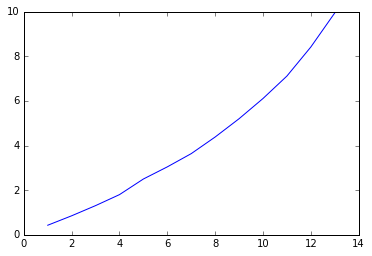

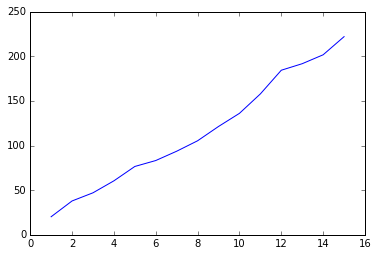

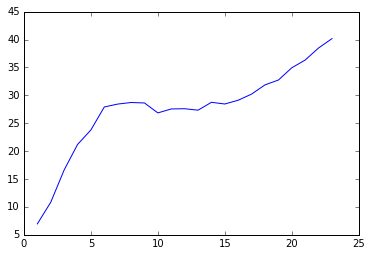

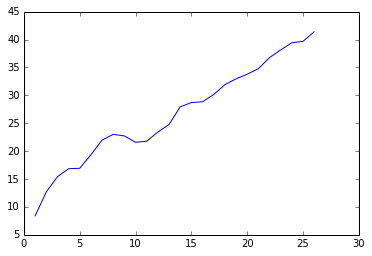

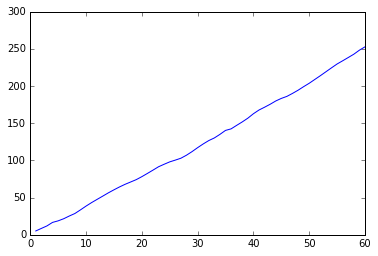

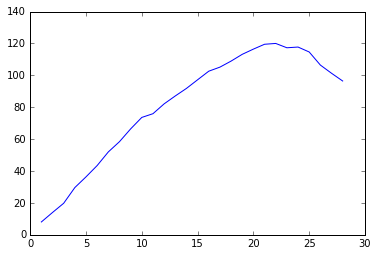

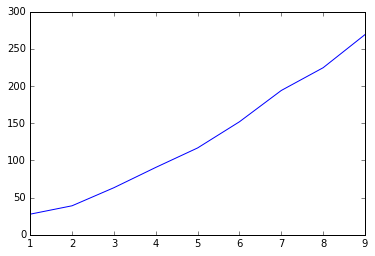

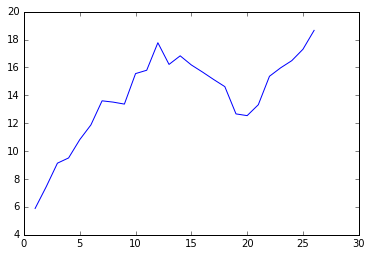

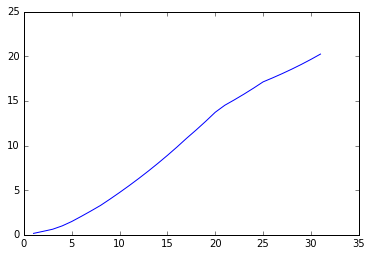

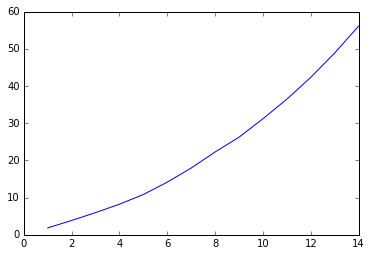

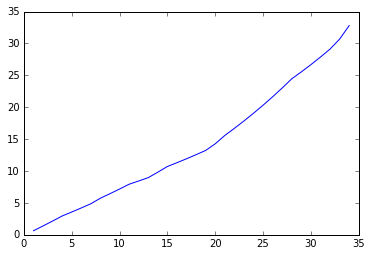

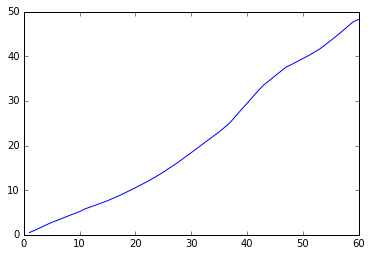

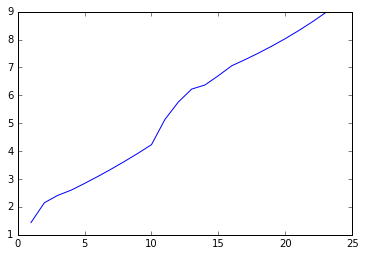

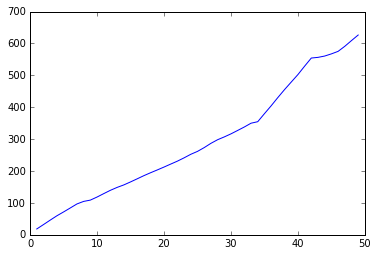

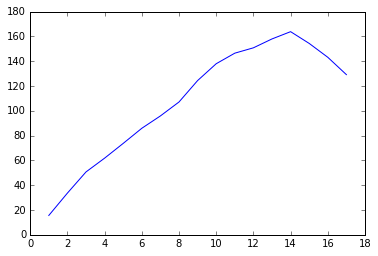

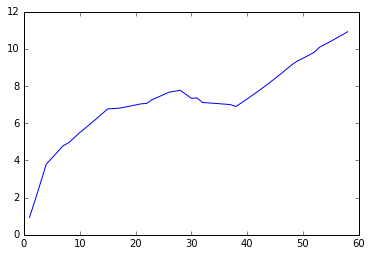

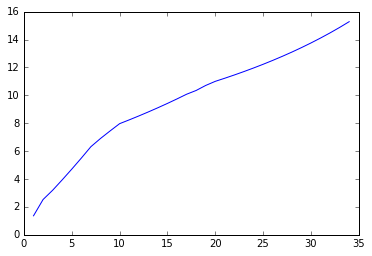

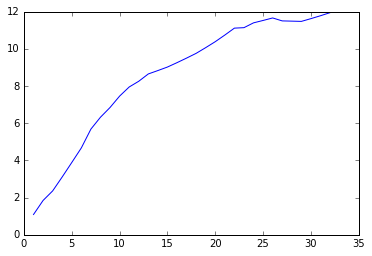

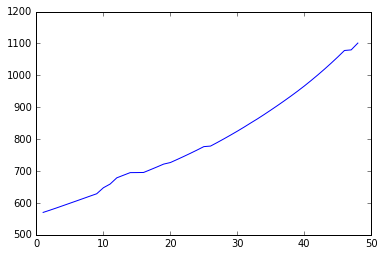

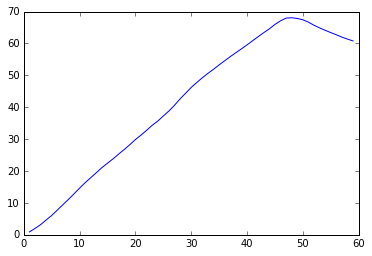

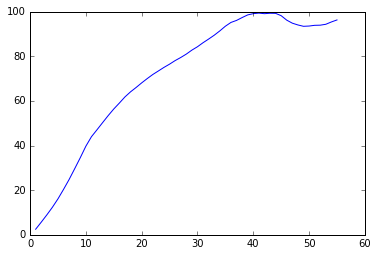

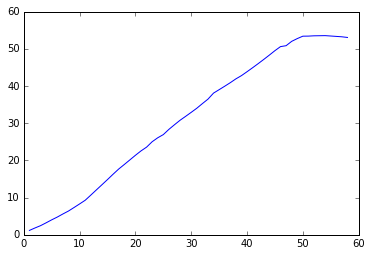

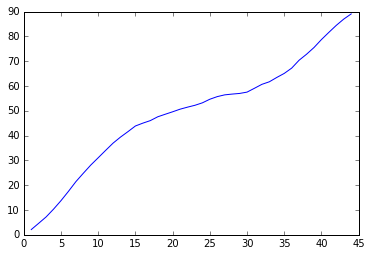

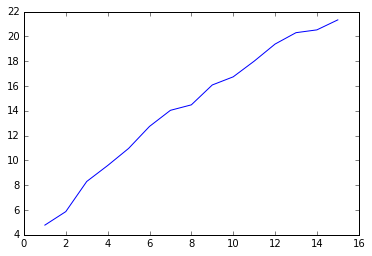

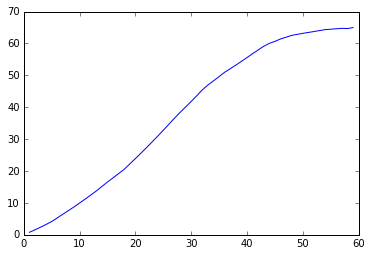

KeyboardInterrupt: 

In [4]:
def low_data_std_values(coords, length_factor=1):
    xs = np.arange(1, int(coords.shape[0] * length_factor))
    ys = [np.mean([np.linalg.norm(track[j + i, 1:] - track[j, 1:])**2 for j in range(track.shape[0] - i)]) for i in xs]
    return xs, ys

def large_data_std_values(tracks, length_factor=1):
    xs = np.arange(1, tracks[0].shape[0])
    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) 
              for i in xs]
    return xs, ys
    
from parser import parse_arsnoc, parse_new_tracks
    
data = parse_arsnoc() + parse_new_tracks()
for track in data:
    if track[0, 0] < 100:
        xs, ys = low_data_std_values(track[:, 1:], 0.5)
        plt.plot(xs, ys)
        plt.show()

In [ ]:
from operator import itemgetter

def t_function(x, alpha, beta):
    return beta * x ** alpha

def prob_penalty(prob):
    return 0 if prob > 0.15 else 1 if prob < 0.1 else 1 - (prob - 0.1) / (0.15 - 0.1)

def calculate_parameters(obsticles, visualize=False):
    population, prob = generate_population(obsticles, PART_CNT, MIN_R, MAX_R, 0.05)
    if population is None:
        return float('Inf')
    tracks = build_tracks(population, obsticles, TRACK_SIZE)

    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) 
              for i in range(0, tracks[0].shape[0])]
    xs = np.arange(len(ys))
    popt, _ = sp.optimize.curve_fit(t_function, xs, ys, [1, 1])
    
    if visualize:
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(xs, ys)
        ax1.plot(xs, t_function(xs, *popt))
        
        ax2 = fig.add_subplot(1, 2, 2)
        circles(0, 0, R, c='b')
        for obsticle in obsticles:
            circles(*obsticle[:N-1], obsticle[N], c='r')
        for (i, track) in enumerate(tracks):
            ax2.plot(track[:, 0], track[:, 1])
        plt.show()
        
    return popt[0] + prob_penalty(prob)

F_CNT = 10

def calculate_fitness(being, visualize=False):
    return np.mean([calculate_parameters(generate_points(*being), visualize) for i in range(F_CNT)])

/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


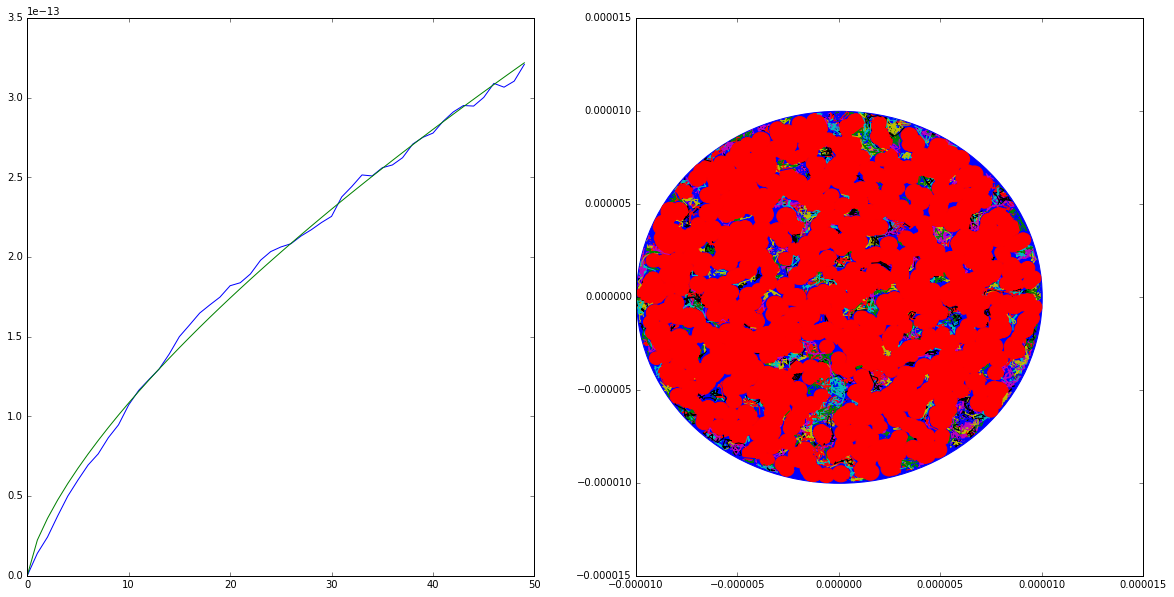

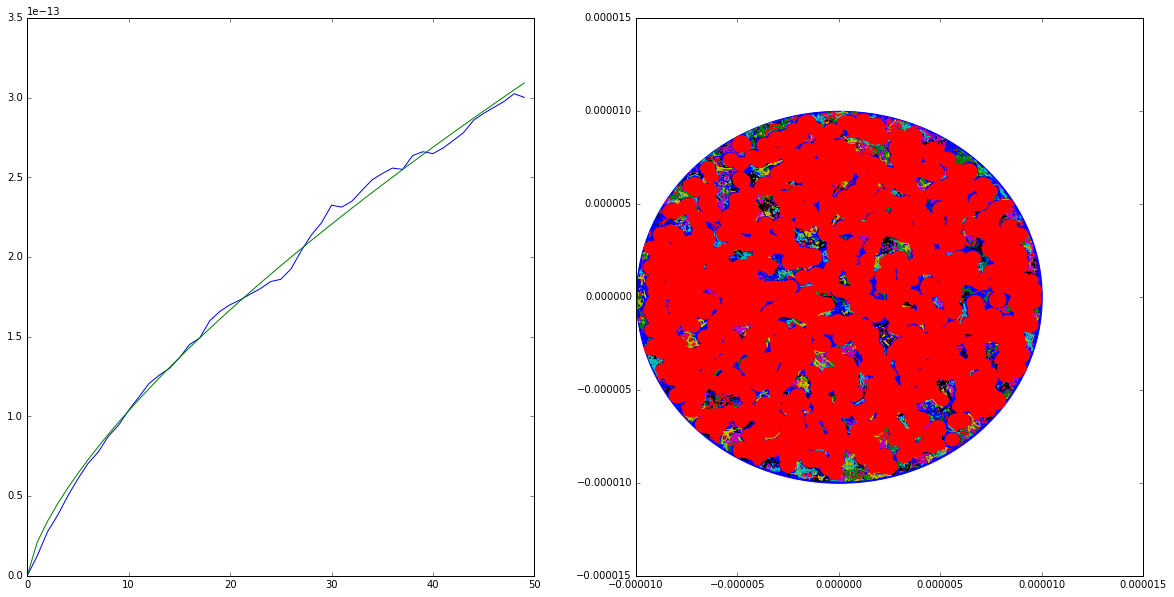

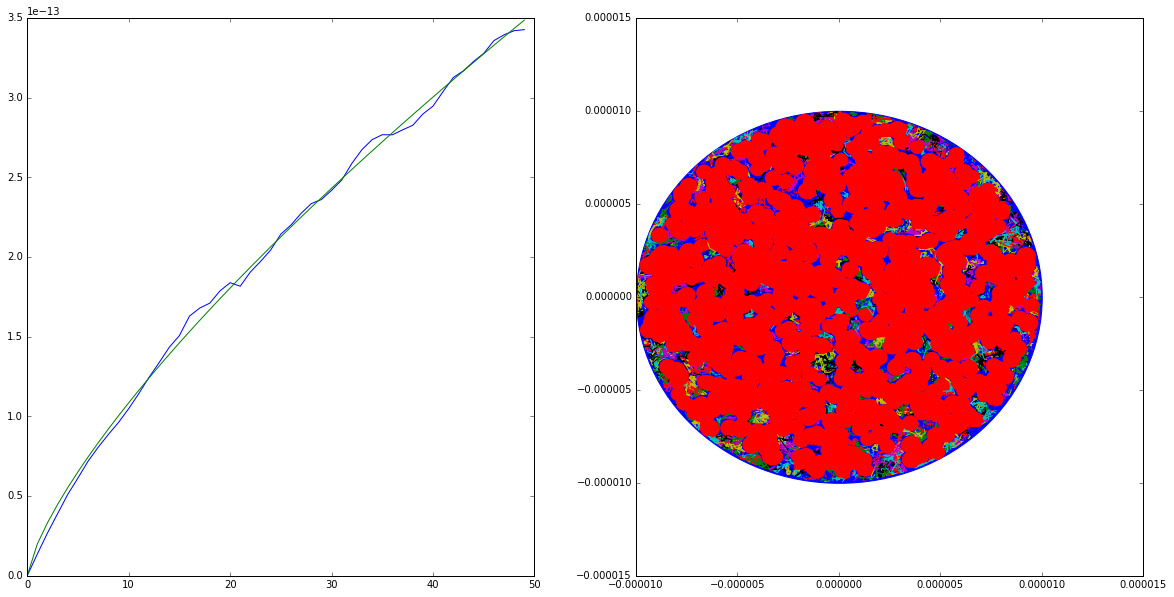

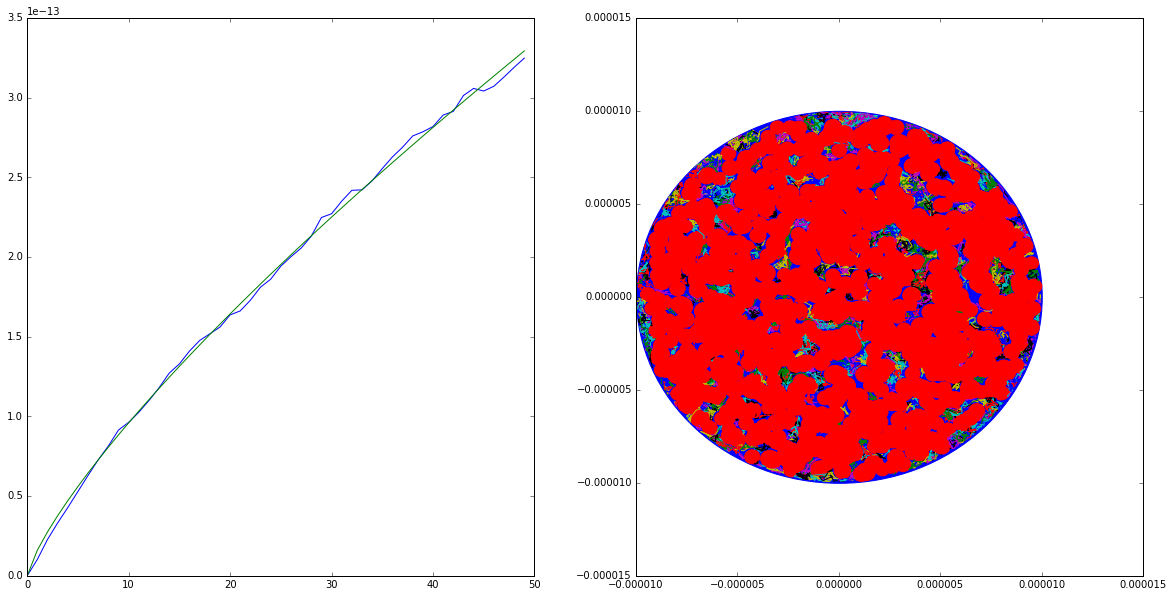

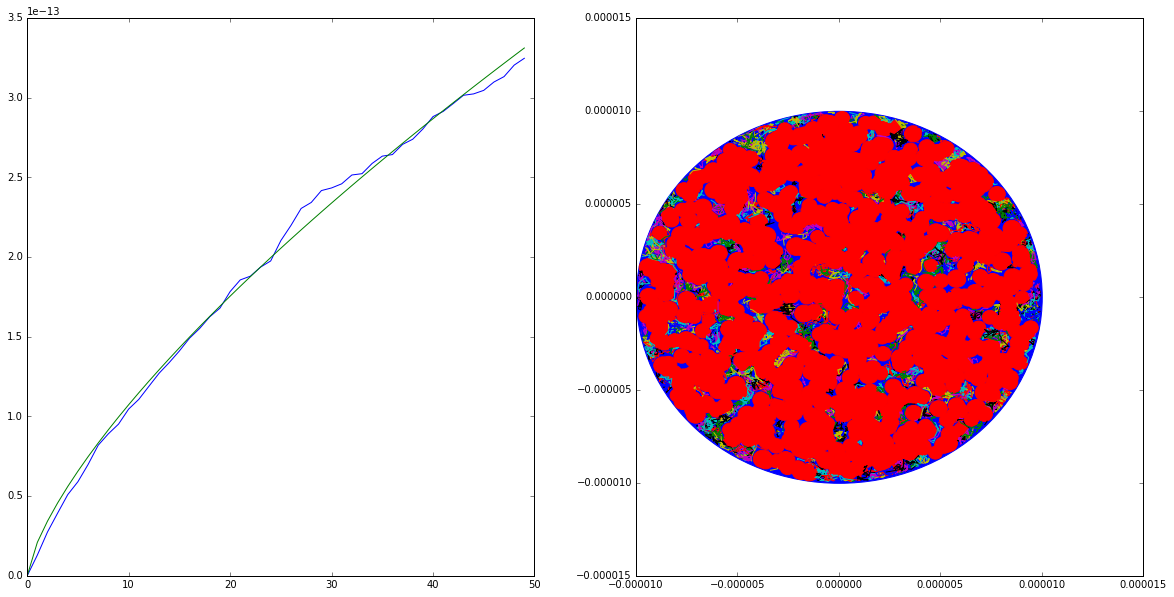

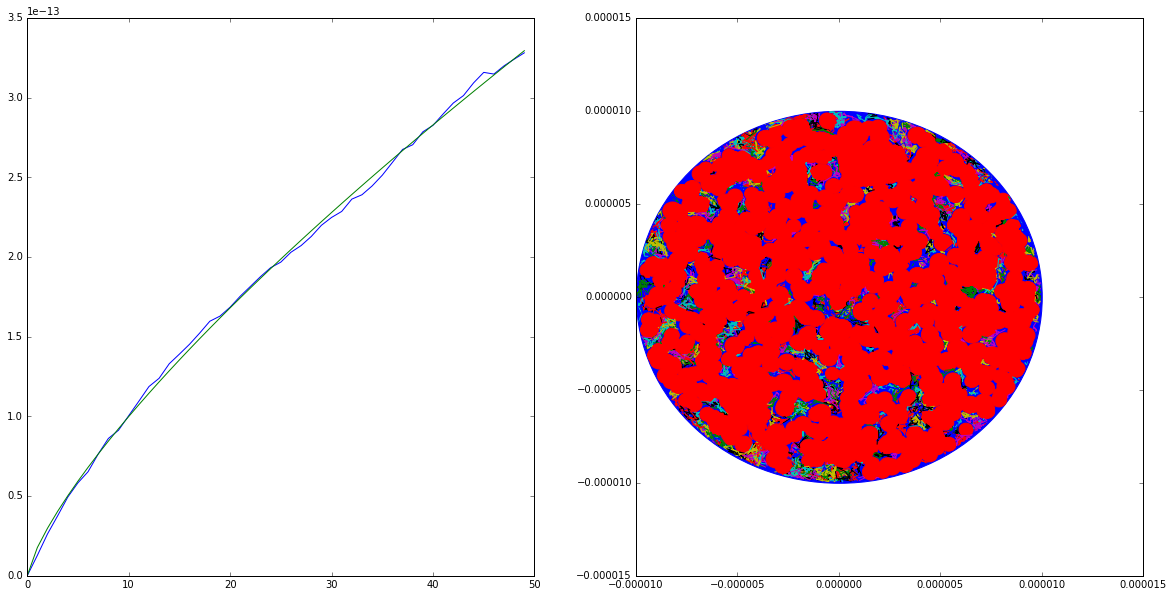

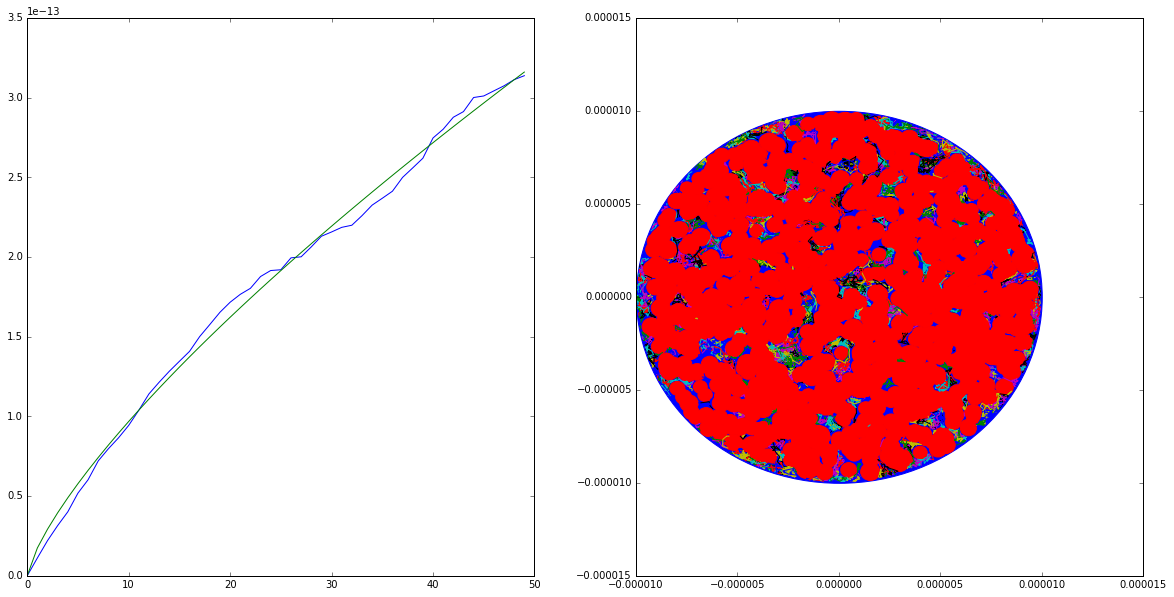

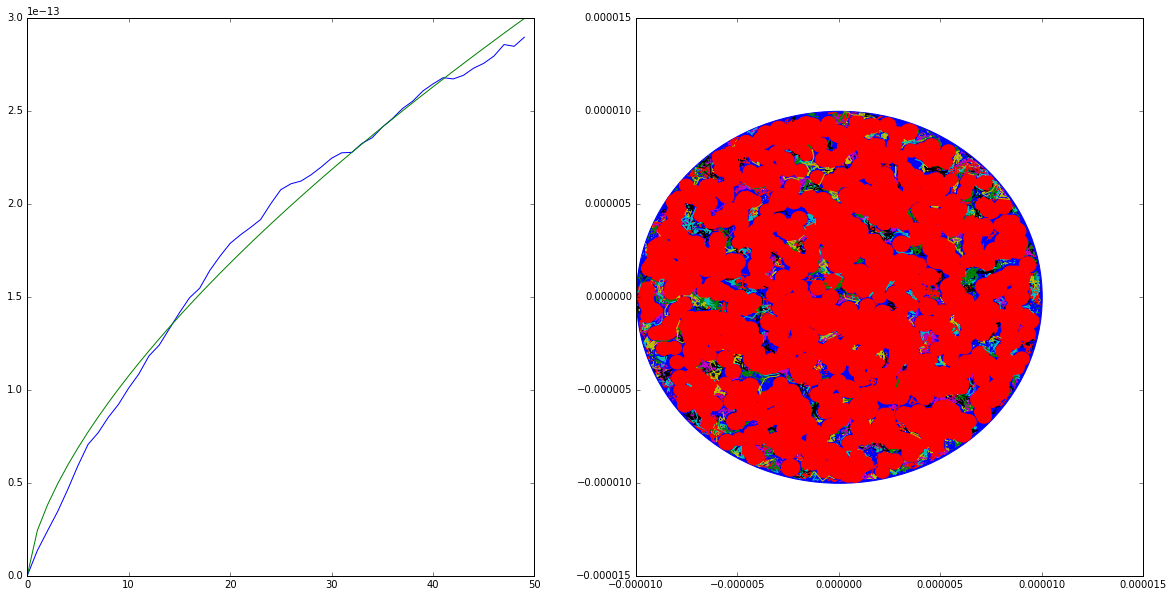

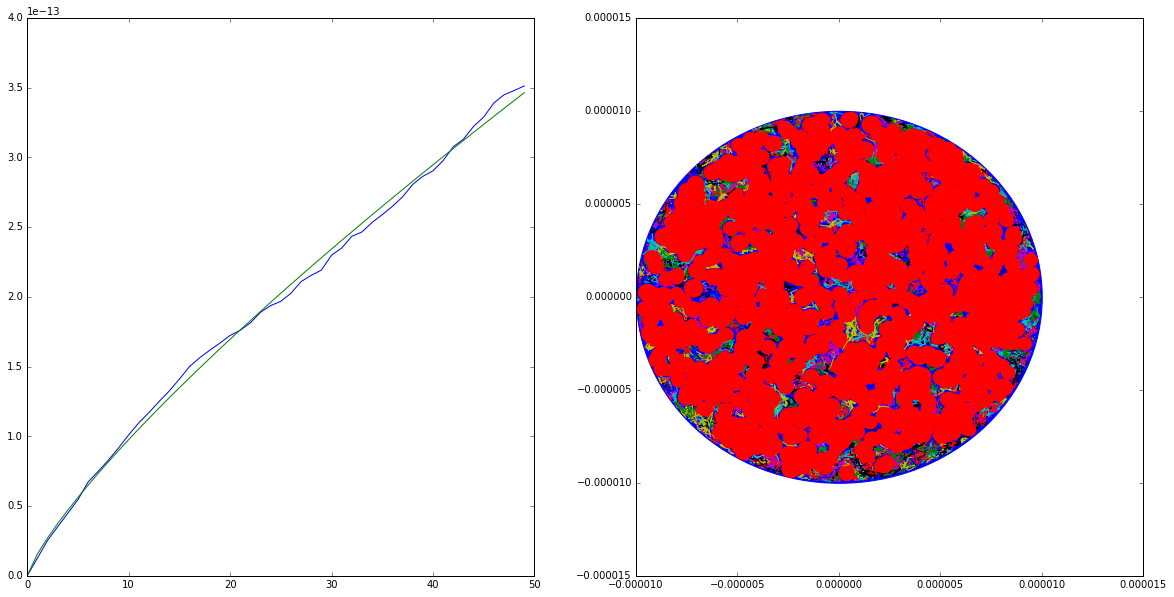

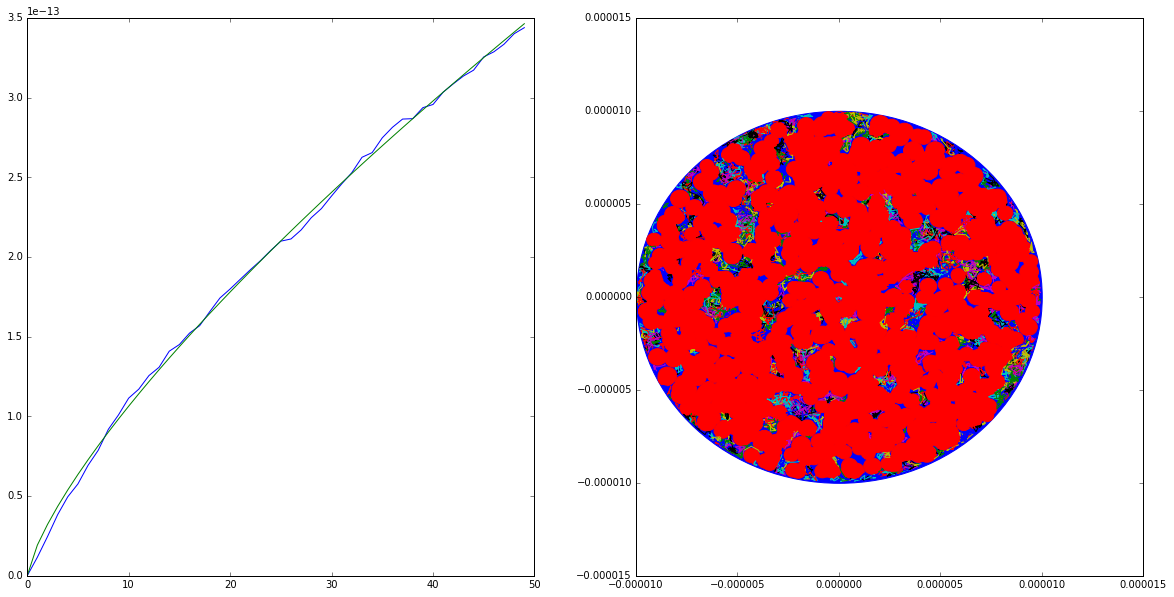

In [47]:
best_fitness = calculate_fitness(sorted_generation[0], True)

In [48]:
print(sorted_generation[0])

[  9.46410298e+02   4.78572663e-07   3.42161781e-07]


10
10


/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/george/envs/mlenv/lib/python3.5/site-p

Best fitness: 0.9338521688139483


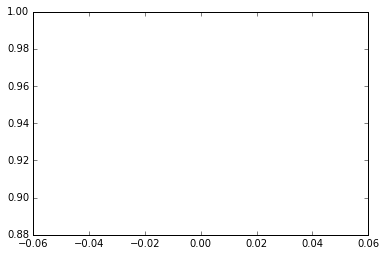

110
Best fitness: 0.9198103396479276


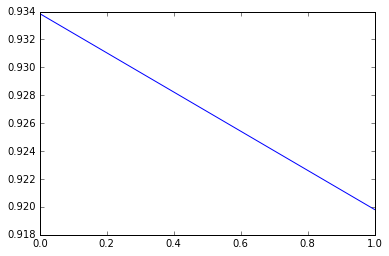

110
Best fitness: 0.9394231199727141


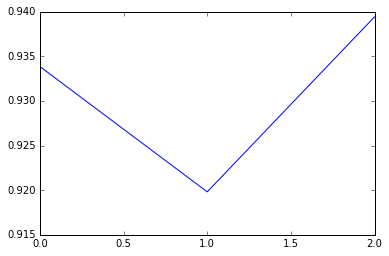

110
Best fitness: 0.9352708372047308


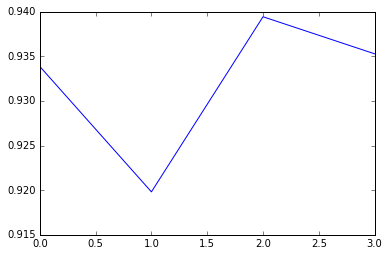

110
Best fitness: 0.9393584809809953


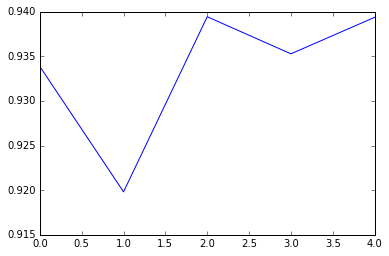

110
Best fitness: 0.9182456132600265


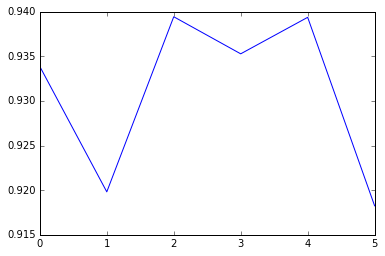

110
Best fitness: 0.937076067598657


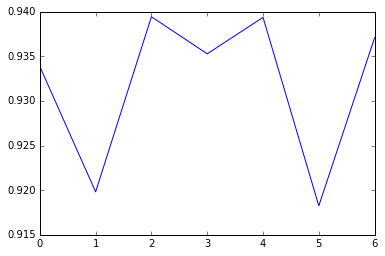

110
Best fitness: 0.9118741178443486


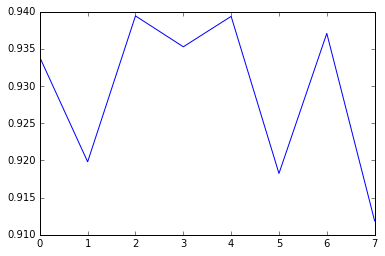

110
Best fitness: 0.9291201519401276


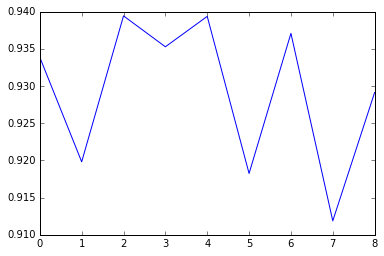

110
Best fitness: 0.9086902725966068


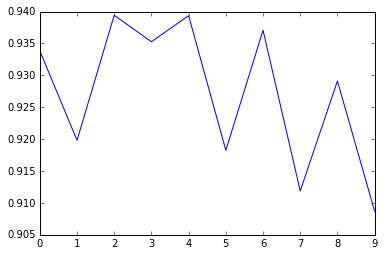

110
Best fitness: 0.9020895153394572


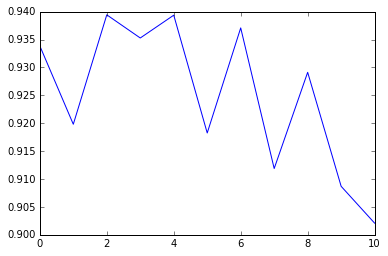

110
Best fitness: 0.9058994851347745


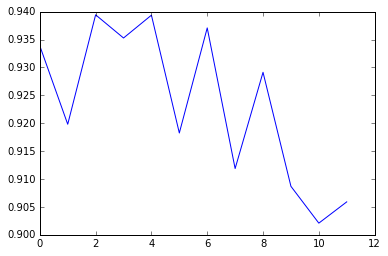

110
Best fitness: 0.8811608869557608


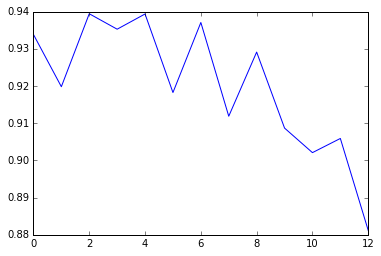

110
Best fitness: 0.9126550652233579


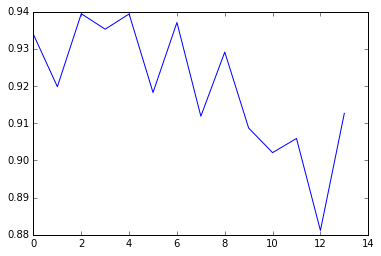

110
Best fitness: 0.9035140279405386


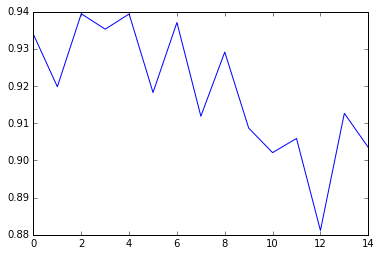

110
Best fitness: 0.900720959847267


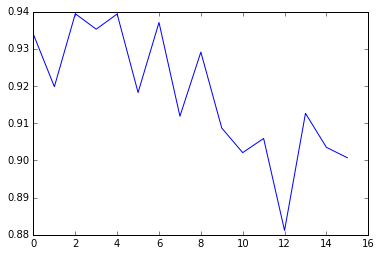

110
Best fitness: 0.9017153459523172


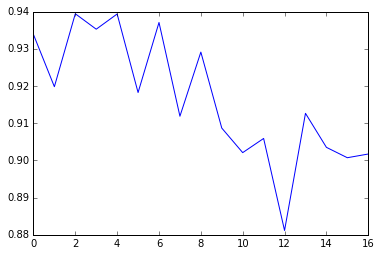

110
Best fitness: 0.888839566947414


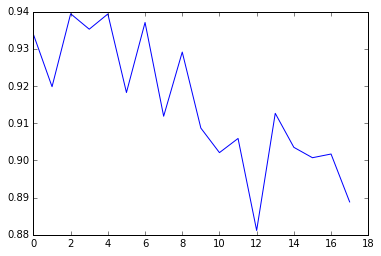

110
Best fitness: 0.8681432299454329


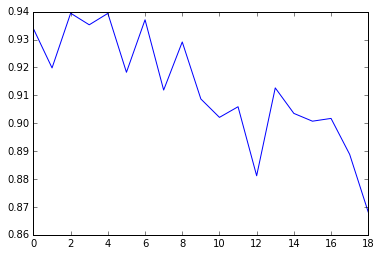

110
Best fitness: 0.8543686166958049


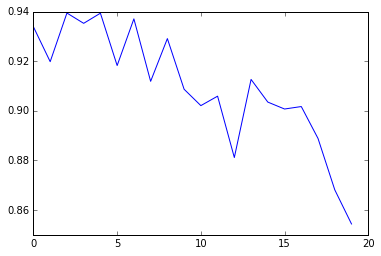

110
Best fitness: 0.8809998830311475


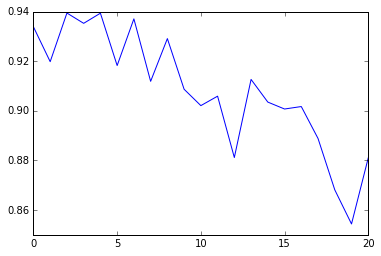

110
Best fitness: 0.8555254047522837


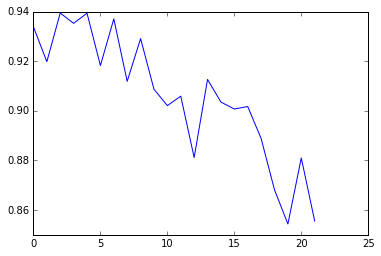

110
Best fitness: 0.865960661452935


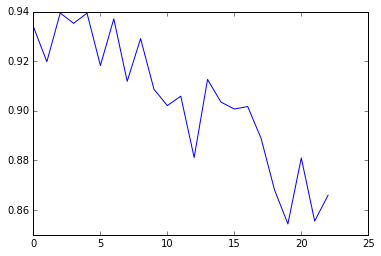

110
Best fitness: 0.8608584370686143


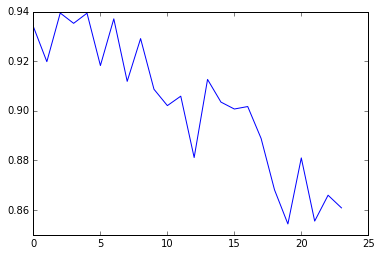

110
Best fitness: 0.871844103152575


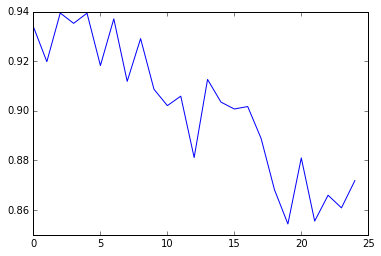

110
Best fitness: 0.8481366513205659


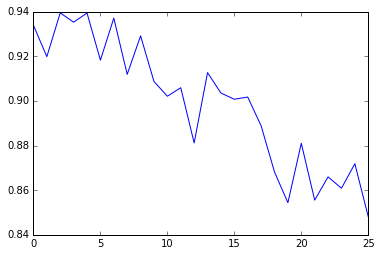

110
Best fitness: 0.8704559845515369


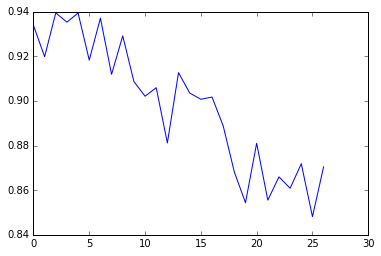

110
Best fitness: 0.8544462443592458


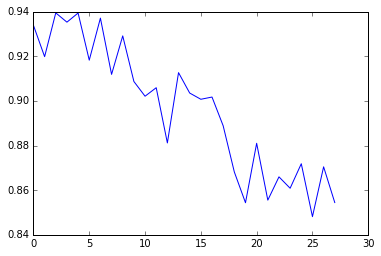

110
Best fitness: 0.8643781414021101


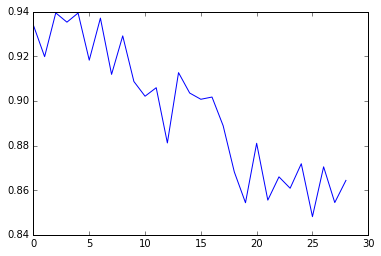

110
Best fitness: 0.8560371242958752


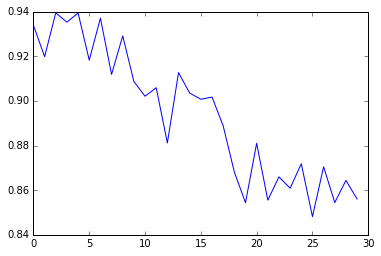

110
Best fitness: 0.8554128147944849


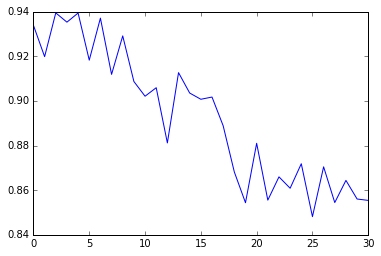

110
Best fitness: 0.8456685606014556


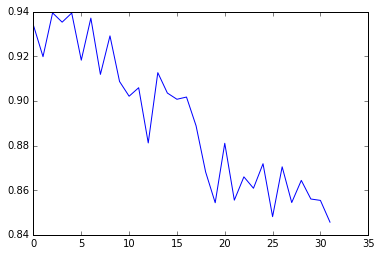

110
Best fitness: 0.8440322697995202


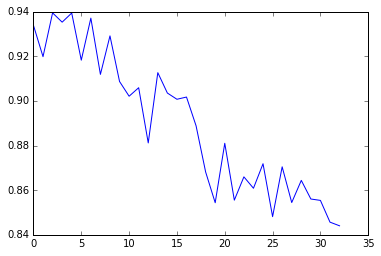

110
Best fitness: 0.8419823083798891


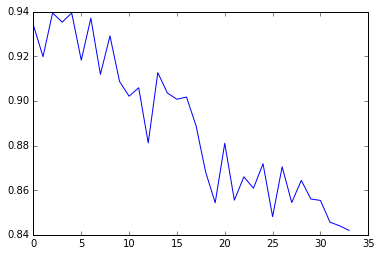

110
Best fitness: 0.84658220178775


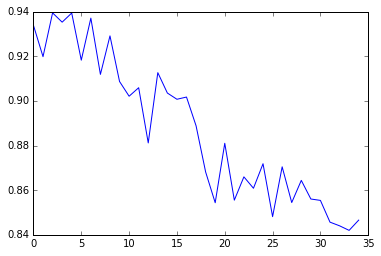

110
Best fitness: 0.8410613782567061


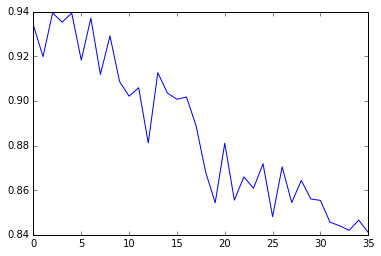

110
Best fitness: 0.8318045479495606


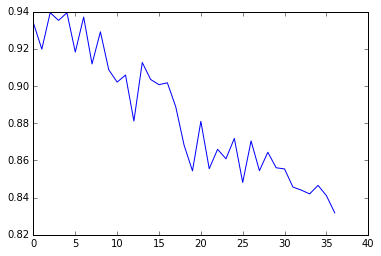

110
Best fitness: 0.8681726319141807


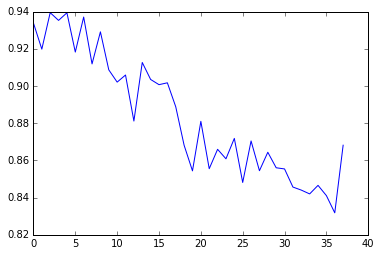

110
Best fitness: 0.844738071147823


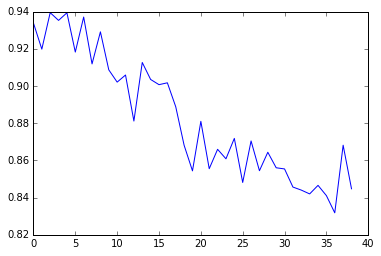

110
Best fitness: 0.8375373505174659


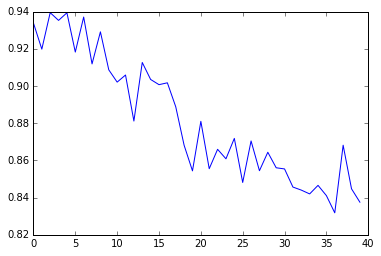

110
Best fitness: 0.8211047883911025


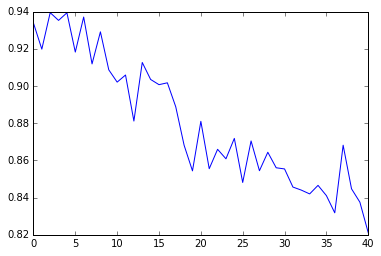

110
Best fitness: 0.8156137947722831


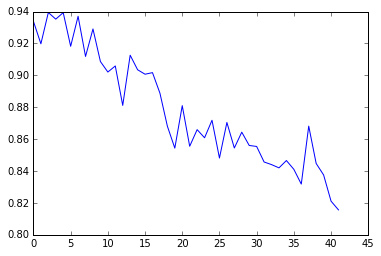

110
Best fitness: 0.8183521299468234


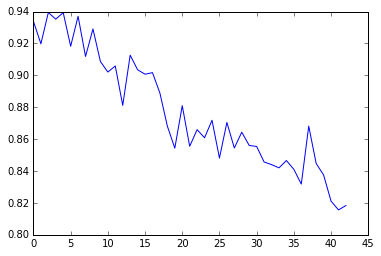

110
Best fitness: 0.8510518075483032


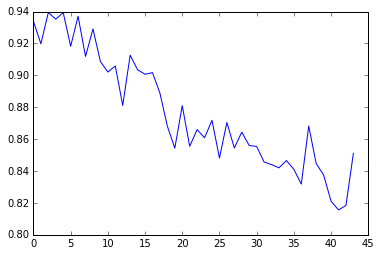

110
Best fitness: 0.8386555516654015


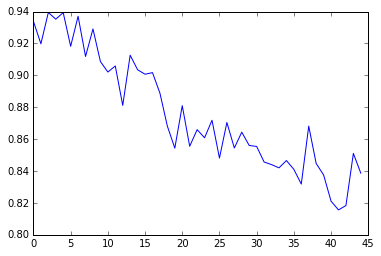

110
Best fitness: 0.8130035926932256


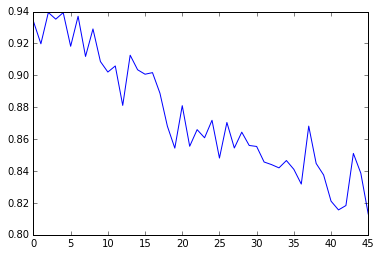

110
Best fitness: 0.8306427776381188


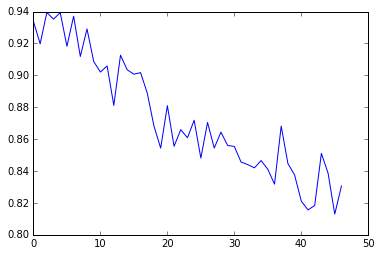

110
Best fitness: 0.8431575164432367


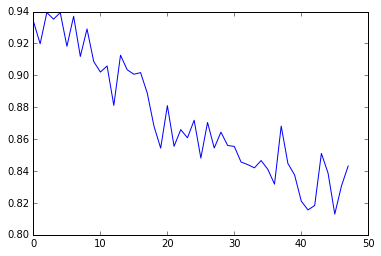

110
Best fitness: 0.827269075668284


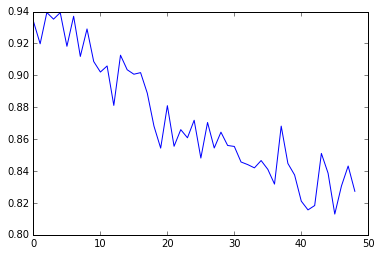

110
Best fitness: 0.8253903123139388


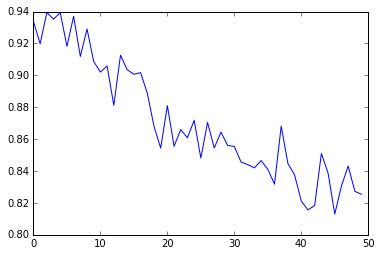

110
Best fitness: 0.8385218962267602


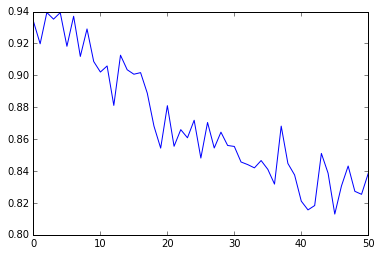

110
Best fitness: 0.8451505248031506


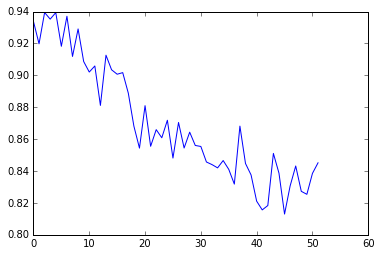

110
Best fitness: 0.8458430040835923


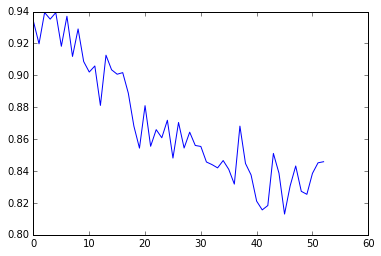

110
Best fitness: 0.8310104145043995


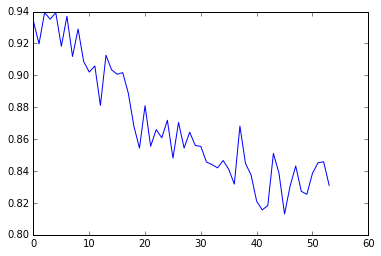

110
Best fitness: 0.8307407870732598


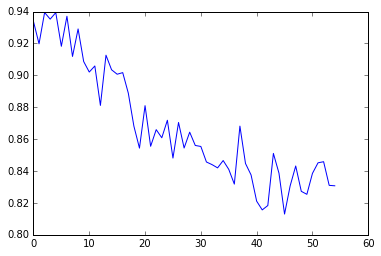

110
Best fitness: 0.8261132546858578


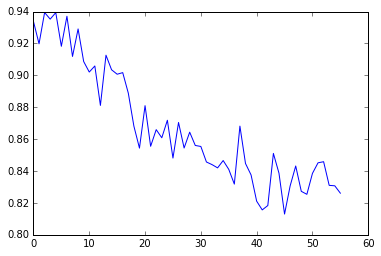

110
Best fitness: 0.8316257547173634


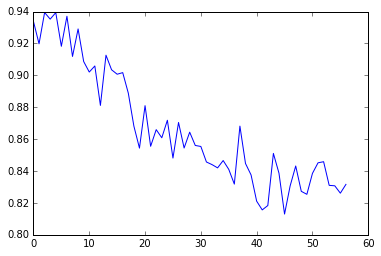

110
Best fitness: 0.8241176116430005


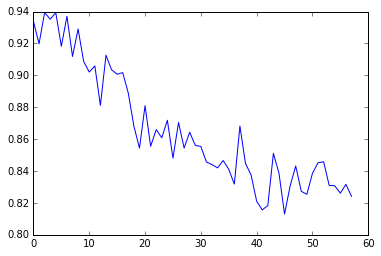

110
Best fitness: 0.8223212421643762


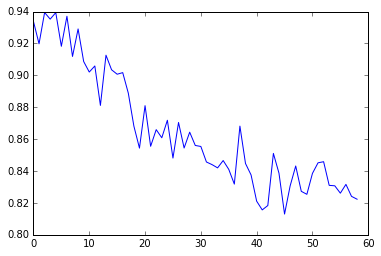

110
Best fitness: 0.812751722322236


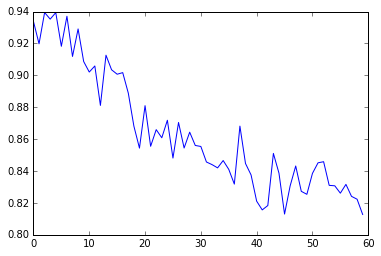

110
Best fitness: 0.824845223500484


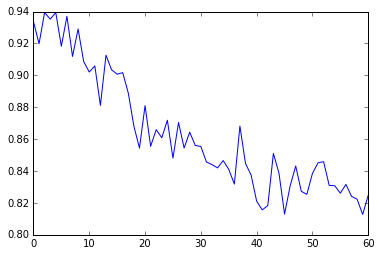

110
Best fitness: 0.8117551392459831


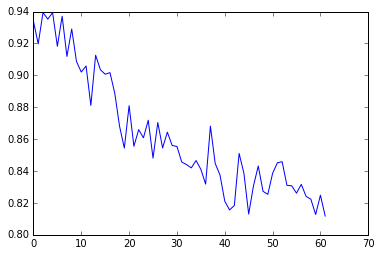

110
Best fitness: 0.825048656267143


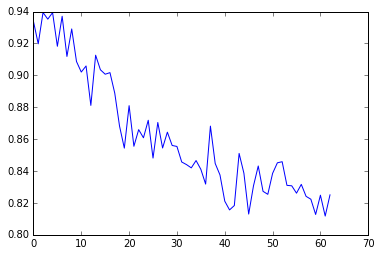

110
Best fitness: 0.8290959494726218


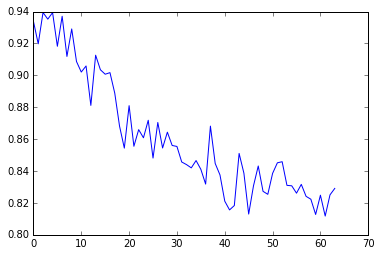

110
Best fitness: 0.8085817114789193


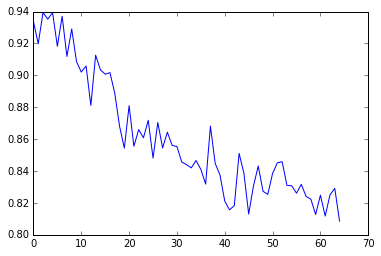

110
Best fitness: 0.8248837235145194


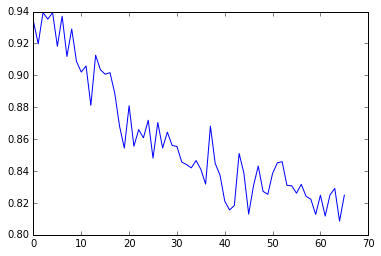

110
Best fitness: 0.8077567987083251


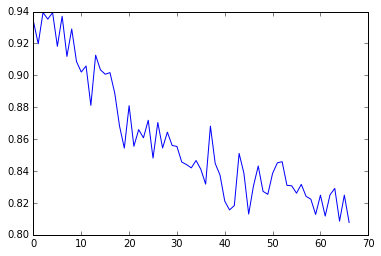

110
Best fitness: 0.8032945529356728


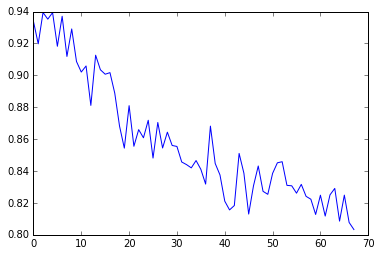

110
Best fitness: 0.80188906699654


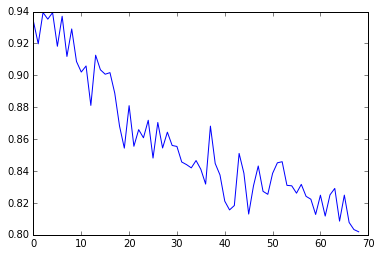

110
Best fitness: 0.8079445943314049


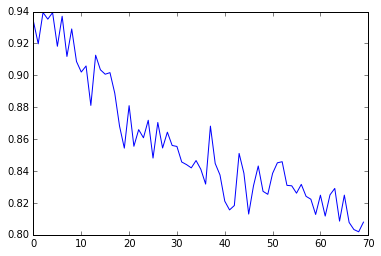

110
Best fitness: 0.8327883904408931


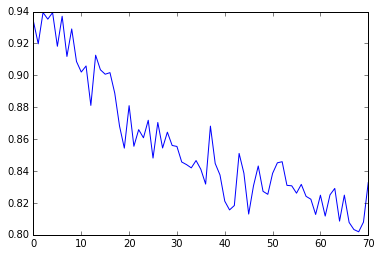

110
Best fitness: 0.8383960023317052


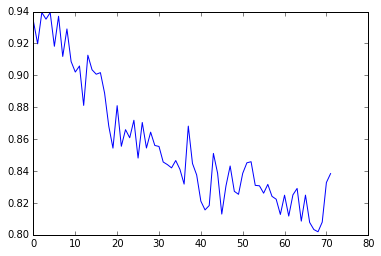

110
Best fitness: 0.8183806200651691


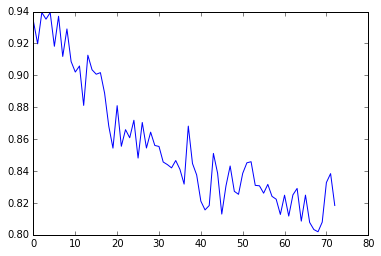

110
Best fitness: 0.815910568737633


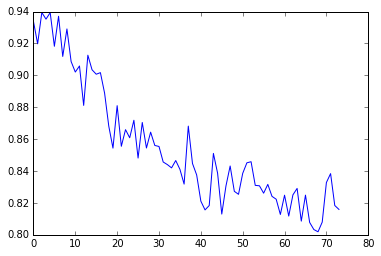

110
Best fitness: 0.814868291921923


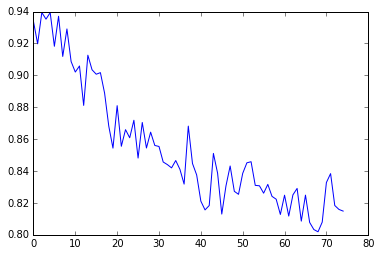

110
Best fitness: 0.8057085736148408


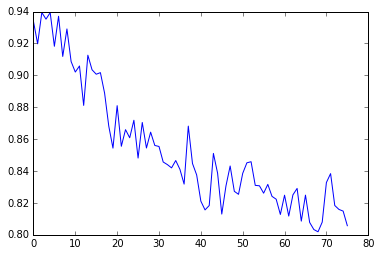

110
Best fitness: 0.8023347240934937


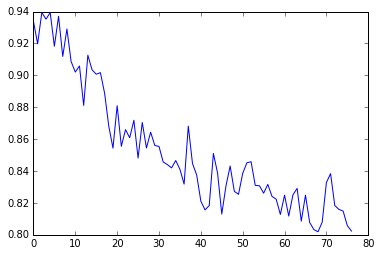

110
Best fitness: 0.7870871103703203


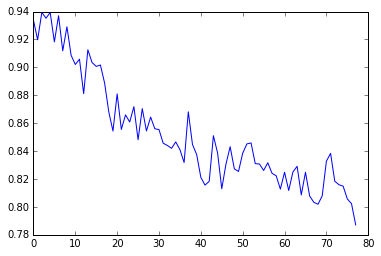

110
Best fitness: 0.7968879121265454


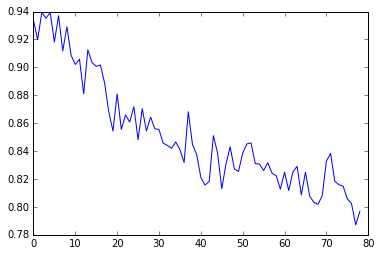

110
Best fitness: 0.7924943390352769


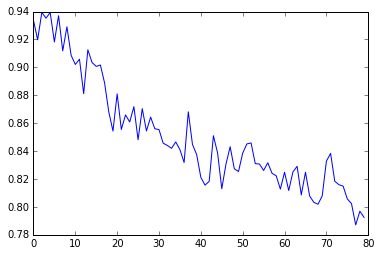

110
Best fitness: 0.7881821313471539


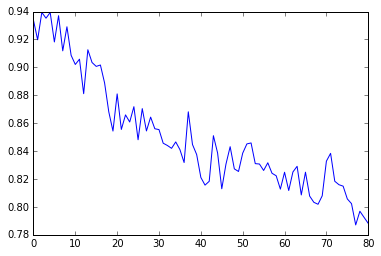

110
Best fitness: 0.7858119624496376


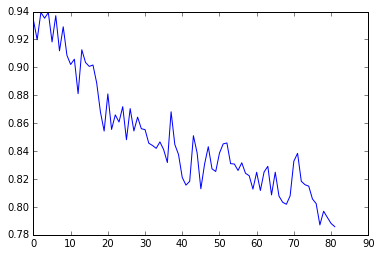

110
Best fitness: 0.7905803257660271


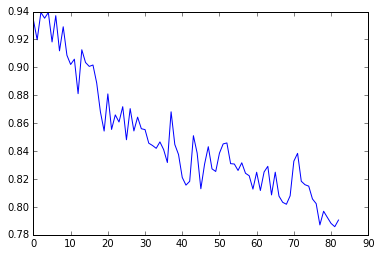

110
Best fitness: 0.8001229033296177


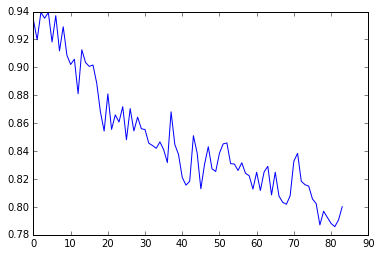

110
Best fitness: 0.7965141616169872


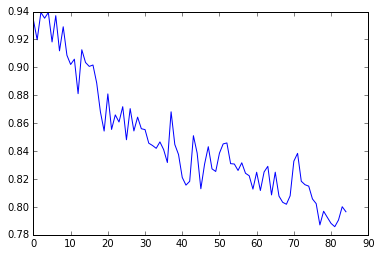

110
Best fitness: 0.7852924751377842


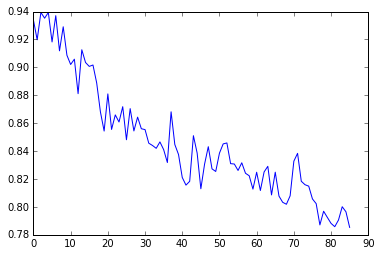

110
Best fitness: 0.8022760326482901


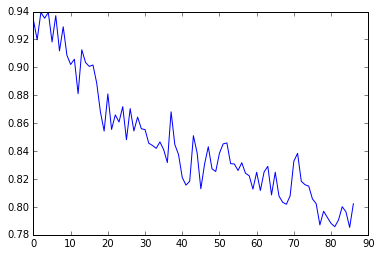

110
Best fitness: 0.8089012733903373


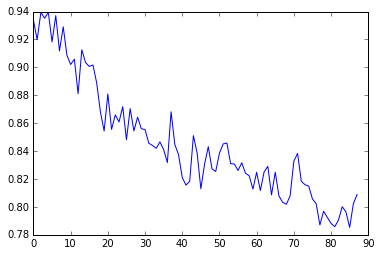

110
Best fitness: 0.8137137781411858


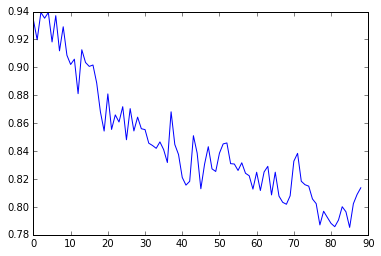

110
Best fitness: 0.7853612141643509


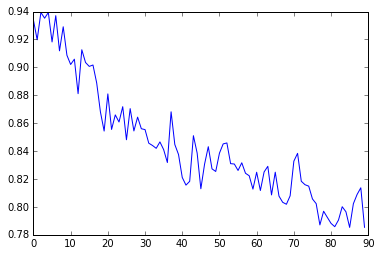

110
Best fitness: 0.8052126234781106


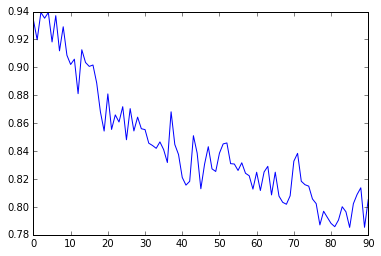

110
Best fitness: 0.7909969414896642


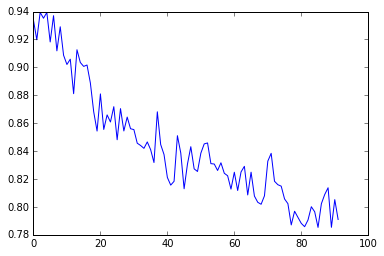

110
Best fitness: 0.8105484987728839


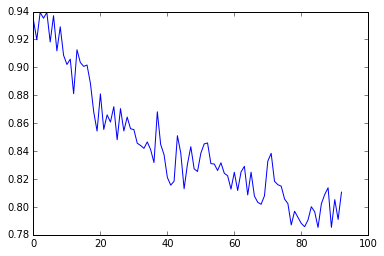

110
Best fitness: 0.7850686009300563


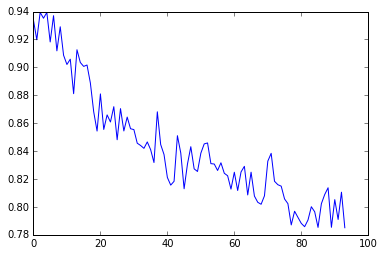

110
Best fitness: 0.7746337983505869


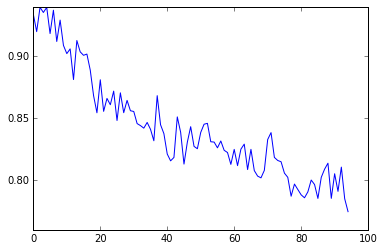

110
Best fitness: 0.7995083321816159


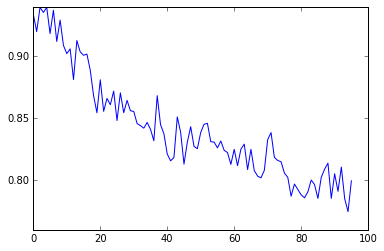

110
Best fitness: 0.7731636249681195


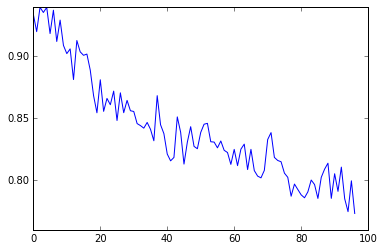

110
Best fitness: 0.7671863107886694


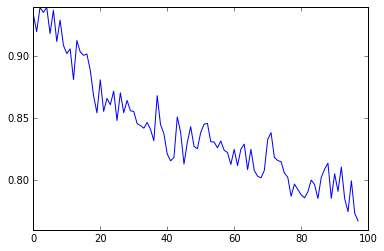

110
Best fitness: 0.8225144194113245


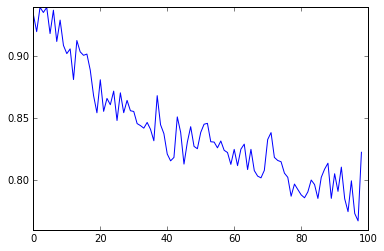

110
Best fitness: 0.7902144934700622


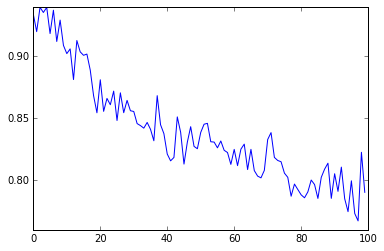

110
Best fitness: 0.7718183650675462


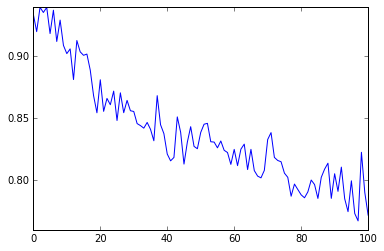

110
Best fitness: 0.7863102282718796


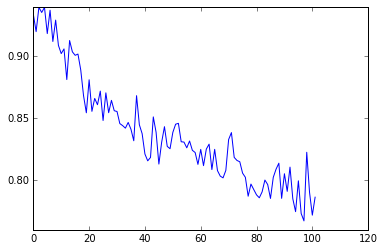

110
Best fitness: 0.7889390646573078


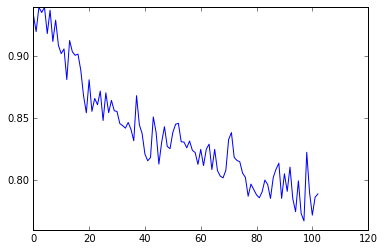

110
Best fitness: 0.7635174103640591


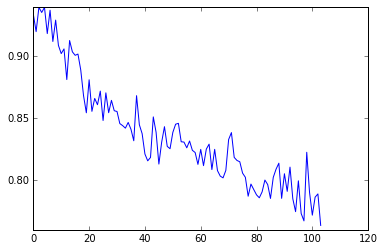

110
Best fitness: 0.7534974595800661


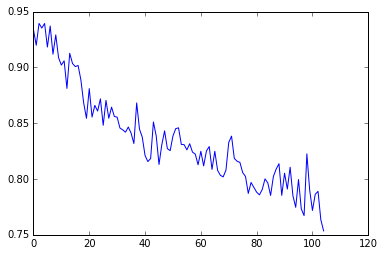

110
Best fitness: 0.7672491996487907


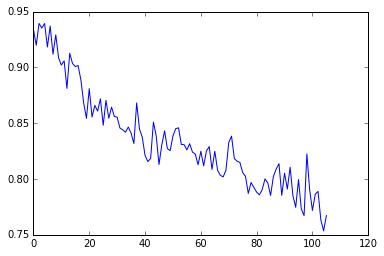

110
Best fitness: 0.767589303294909


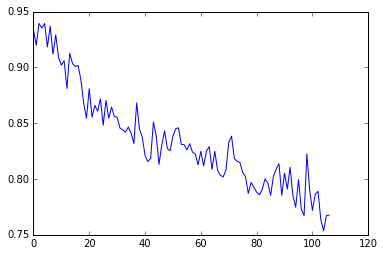

110
Best fitness: 0.7782655415726205


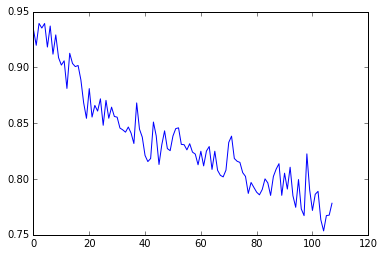

110
Best fitness: 0.7640943811210545


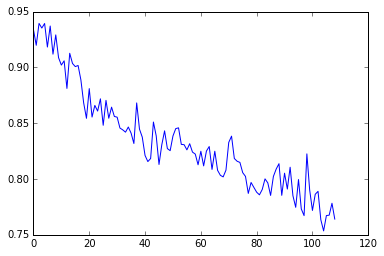

110
Best fitness: 0.761689133438687


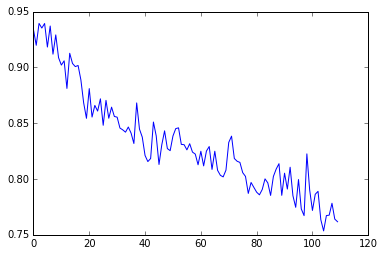

110
Best fitness: 0.7690190577209948


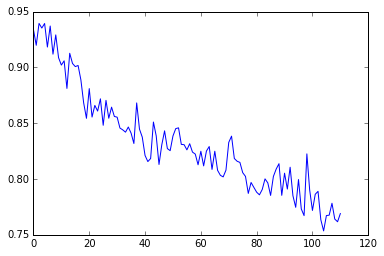

110
Best fitness: 0.7812546067738716


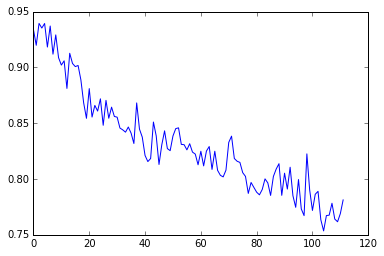

110
Best fitness: 0.7719901984052685


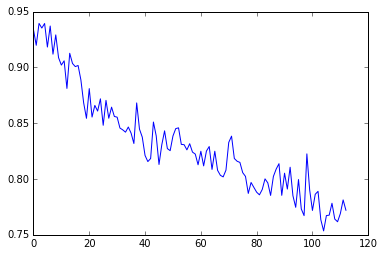

110
Best fitness: 0.7716447645144608


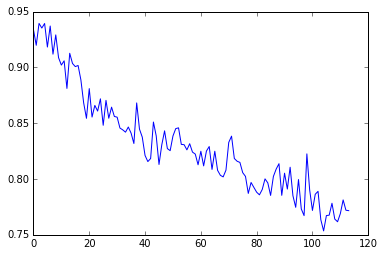

110
Best fitness: 0.760796745202664


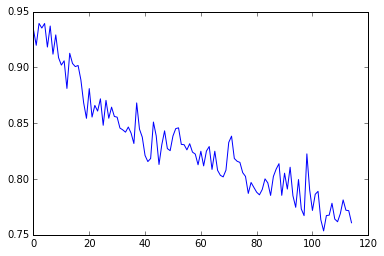

110
Best fitness: 0.7767577917001744


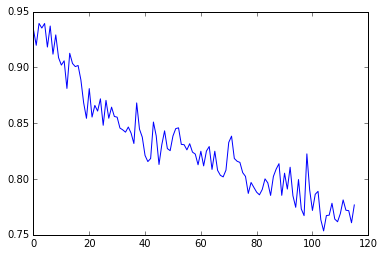

110
Best fitness: 0.7658399498780678


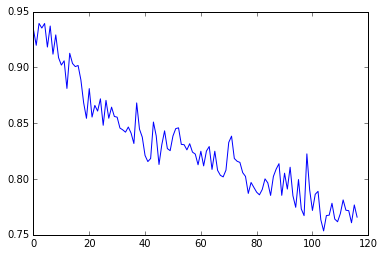

110
Best fitness: 0.7641218605645406


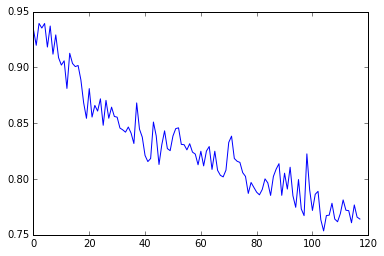

110
Best fitness: 0.7462319450792031


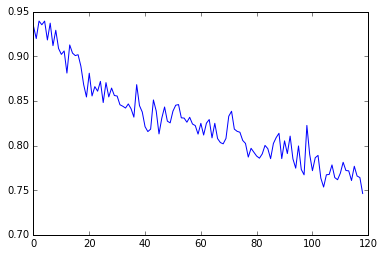

110
Best fitness: 0.7491692744847531


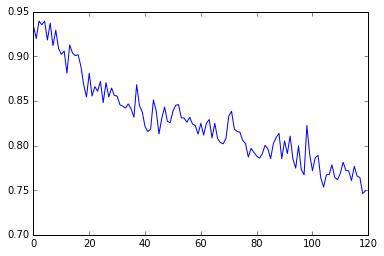

110
Best fitness: 0.8109391677007374


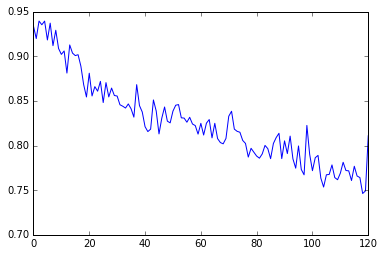

110
Best fitness: 0.767934040471827


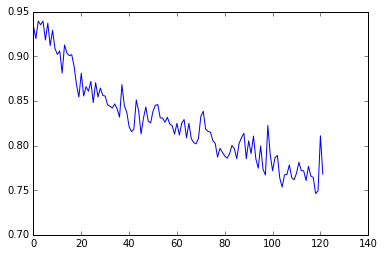

110
Best fitness: 0.8100774499728749


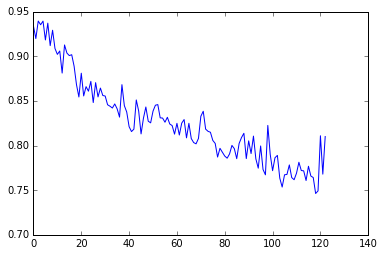

110
Best fitness: 0.7515566674836027


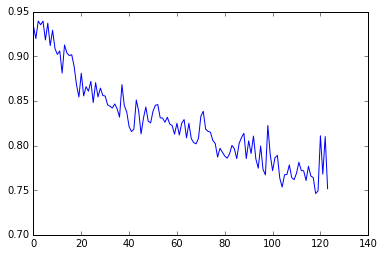

110
Best fitness: 0.8078415357509374


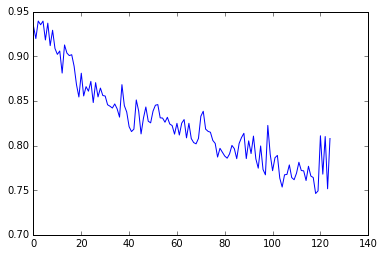

110
Best fitness: 0.7560837769959591


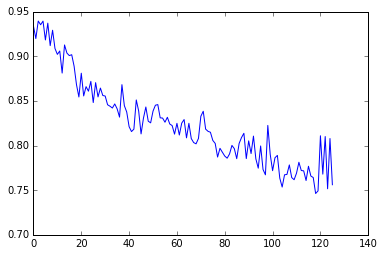

110
Best fitness: 0.7395793078123089


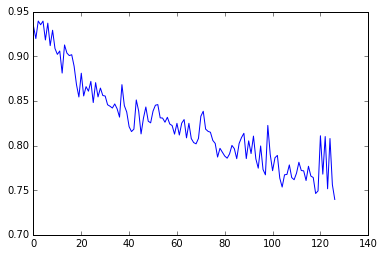

110
Best fitness: 0.7511918814217072


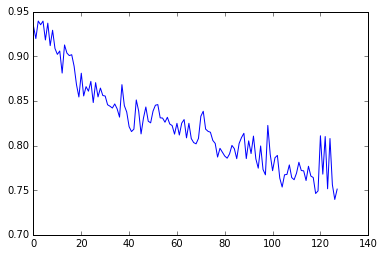

110
Best fitness: 0.7761106385192965


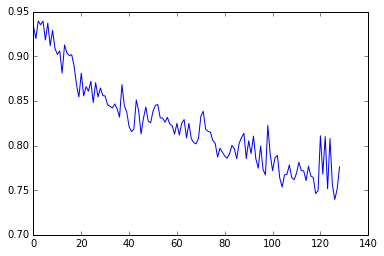

110
Best fitness: 0.7762295776761349


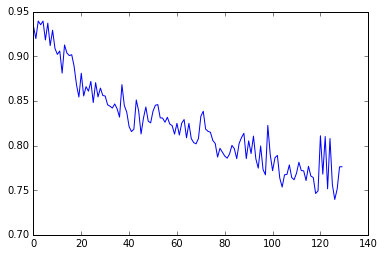

110
Best fitness: 0.7500995815320433


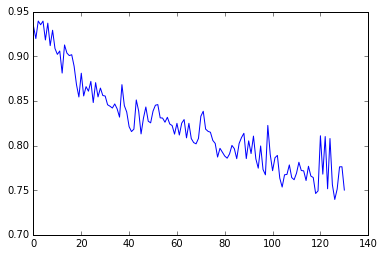

110
Best fitness: 0.7665983258315175


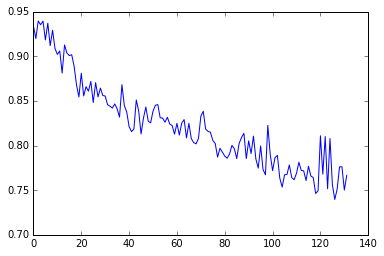

110
Best fitness: 0.785217718463075


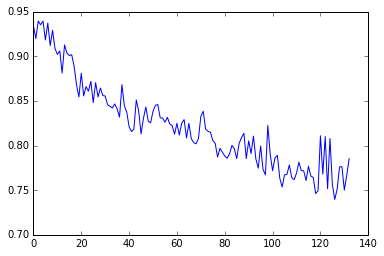

110
Best fitness: 0.7608540528422495


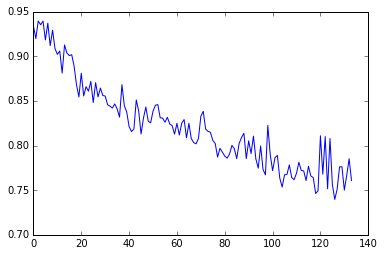

110
Best fitness: 0.7530569502992553


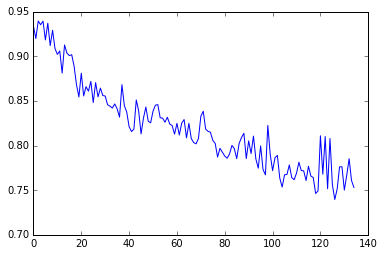

110
Best fitness: 0.7511941141599336


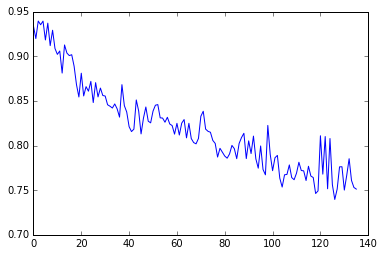

110
Best fitness: 0.728866580361815


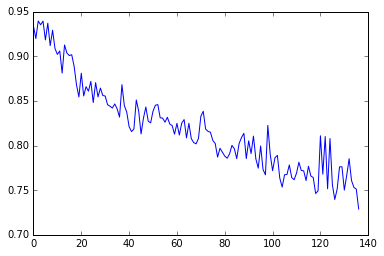

110
Best fitness: 0.7558930411167987


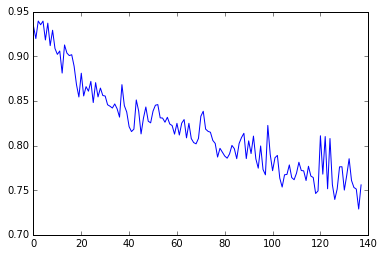

110
Best fitness: 0.7277908632926006


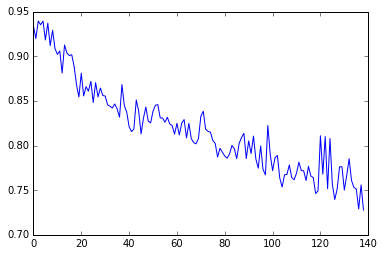

110
Best fitness: 0.7543454200237649


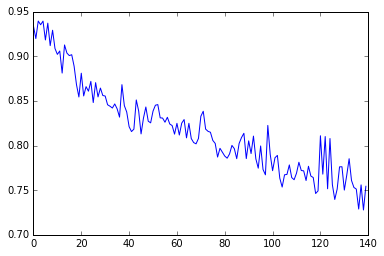

110
Best fitness: 0.773830075209911


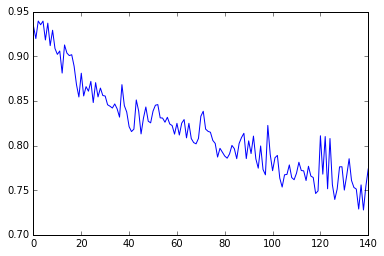

110
Best fitness: 0.7445687284609692


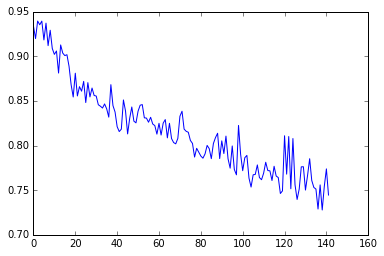

110
Best fitness: 0.7323898613892188


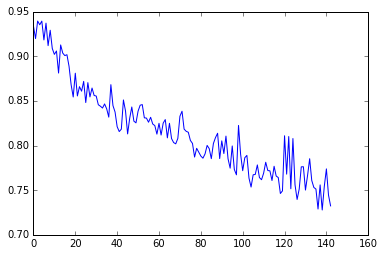

110
Best fitness: 0.7365427372080464


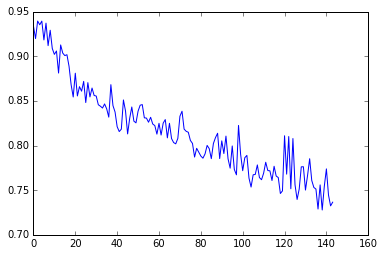

110
Best fitness: 0.7745059097874323


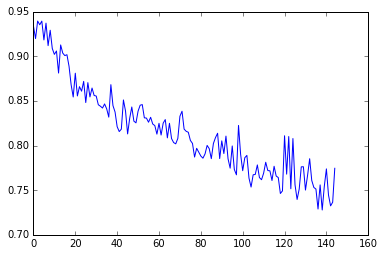

110
Best fitness: 0.7545797715030979


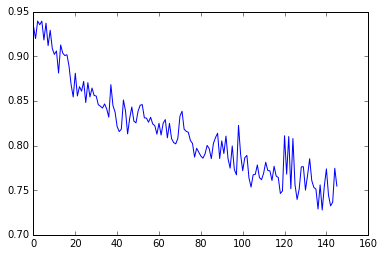

110
Best fitness: 0.750703123866862


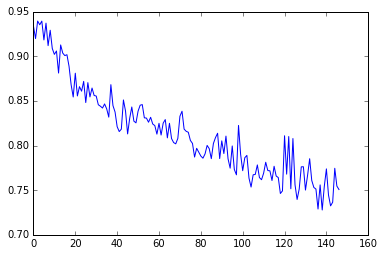

110
Best fitness: 0.745024404318914


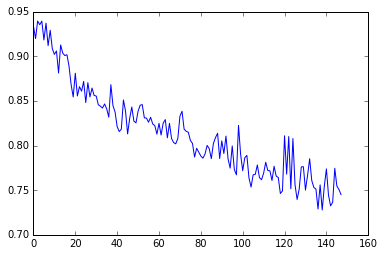

110
Best fitness: 0.7691298326834854


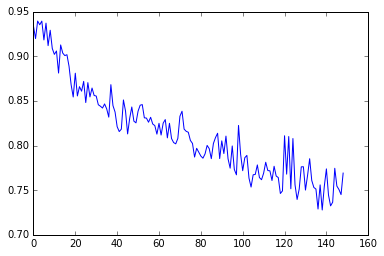

110
Best fitness: 0.7486749979416147


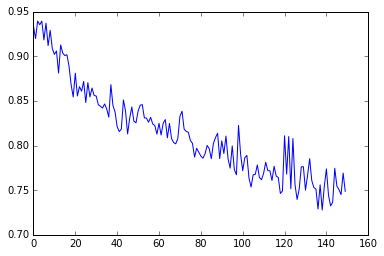

110
Best fitness: 0.7290785616709745


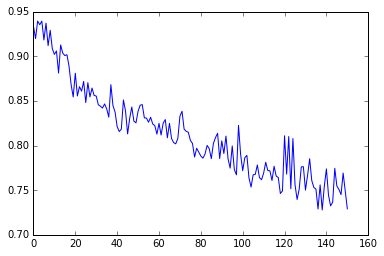

110
Best fitness: 0.7695677632197528


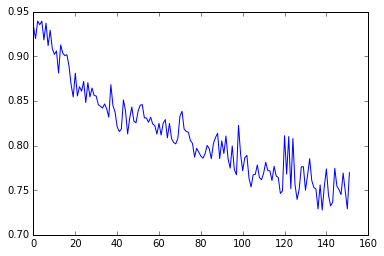

110
Best fitness: 0.7445380416633252


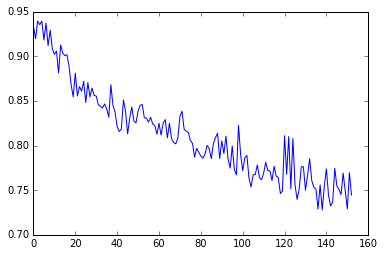

110
Best fitness: 0.7303387923160016


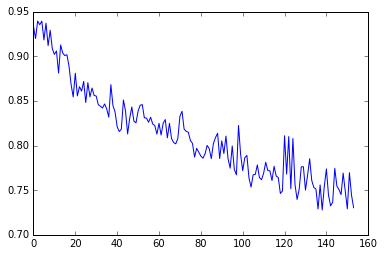

110
Best fitness: 0.7264892012841704


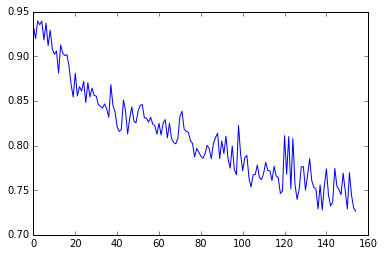

110
Best fitness: 0.7277750346058823


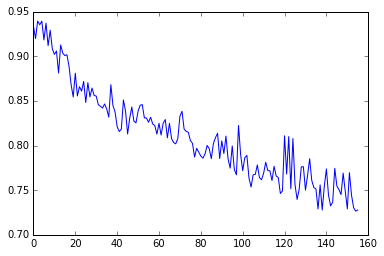

110
Best fitness: 0.7458276678910677


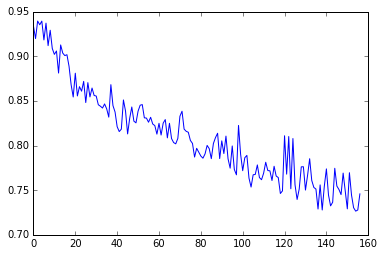

110
Best fitness: 0.7420394980823594


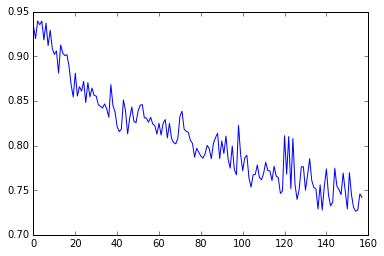

110
Best fitness: 0.7251531916767944


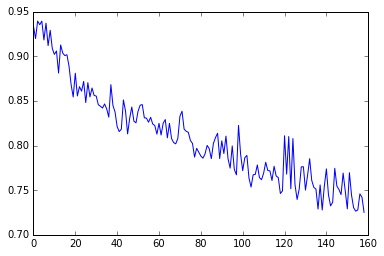

110
Best fitness: 0.7458969220108831


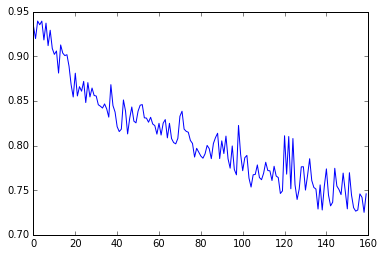

110
Best fitness: 0.750922654244273


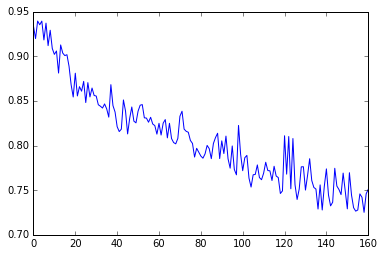

110
Best fitness: 0.7386004625033518


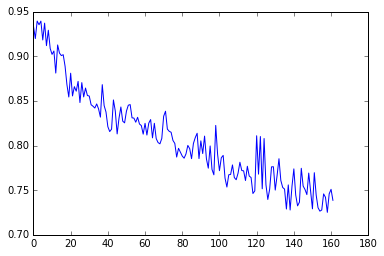

110
Best fitness: 0.7388464380652928


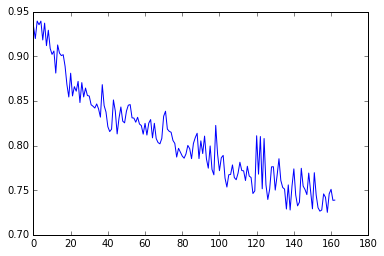

110
Best fitness: 0.7377461443525768


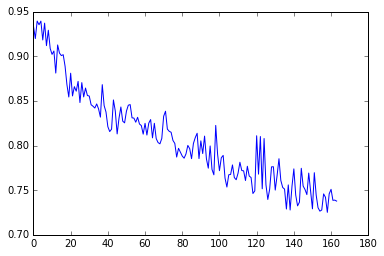

110
Best fitness: 0.7400319887082601


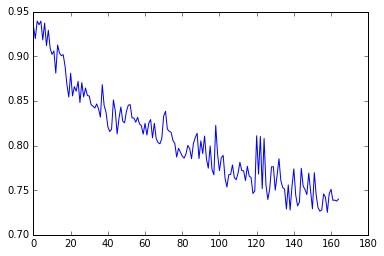

110
Best fitness: 0.7759446252415005


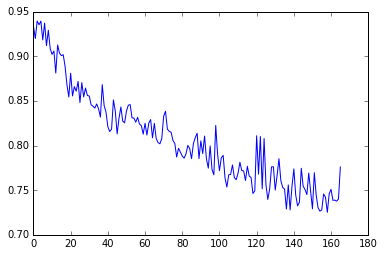

110
Best fitness: 0.7206399150378834


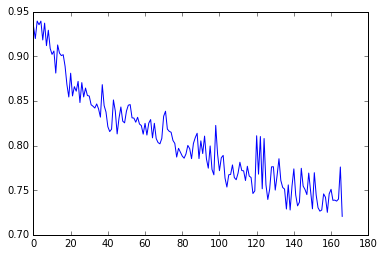

110
Best fitness: 0.7172975358686721


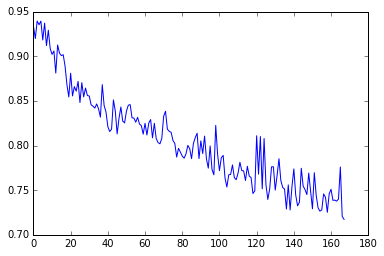

110
Best fitness: 0.7089580678090268


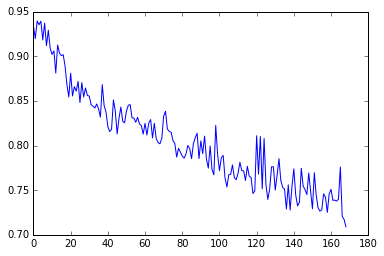

110
Best fitness: 0.6933506733846801


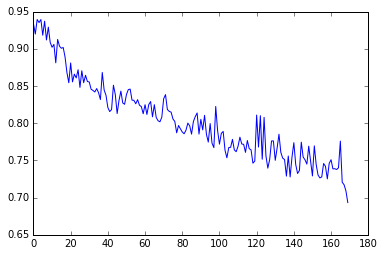

110
Best fitness: 0.727883595863896


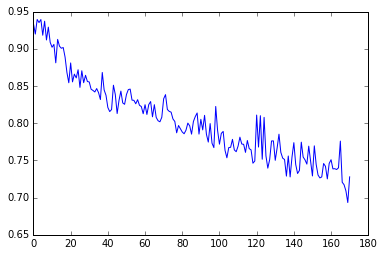

110


Process ForkPoolWorker-1086:
Process ForkPoolWorker-1087:
Traceback (most recent call last):
Process ForkPoolWorker-1089:
Traceback (most recent call last):
Process ForkPoolWorker-1090:
Process ForkPoolWorker-1088:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, i

KeyboardInterrupt: 

In [46]:
def choose(array, indexes):
    return np.multiply(array.T, indexes).T 

def cross(being1, being2):
    indexes = np.random.choice([0, 1], size=being1.shape[0])
    return choose(being1, indexes) + choose(being2, 1 - indexes)

def mutate(being):
    next_being = being * (1 + np.random.randn(*being.shape) * 0.03)
    return next_being

def next_generation(generation):
    return [mutate(cross(being1, being2)) for being1 in generation for being2 in generation]

from multiprocessing import Pool

def sort_with_fitness(generation, fitness_function):
    print(len(generation))
    with Pool(5) as pool:
        fitnesses = pool.map(fitness_function, generation)
    sorted_zipped = sorted(zip(fitnesses, generation), key=itemgetter(0))
    sorted_beings = [being for (fitness, being) in sorted_zipped]
    sorted_fitnessess = [fitness for (fitness, being) in sorted_zipped]
    return sorted_beings, sorted_fitnessess

GEN_SIZE = 10
generation = [np.array([OBST_CNT, O_MIN_R, O_MAX_R]) for i in range(GEN_SIZE)]
print(len(generation))

best_fitnesses = []

while True:
    sorted_generation, sorted_fitnesses = sort_with_fitness(generation, calculate_fitness)
    best_fitness = calculate_fitness(sorted_generation[0], False)
    print('Best fitness: {}'.format(best_fitness))    
    
    best_fitnesses.append(best_fitness)
    plt.plot(np.arange(len(best_fitnesses)), best_fitnesses)
    plt.show()
    
    generation = next_generation(sorted_generation[:GEN_SIZE]) + sorted_generation[:GEN_SIZE] 

In [ ]:
def t_function(x, alpha, beta):
    return beta * x**alpha

for i in range(10):
    start_time = time.time()
    population, obsticles = generate_population_obsticles(100, OBST_CNT)
    end_time = time.time()
    print('{} to generate {} population with {} obsticles'
          .format(end_time - start_time, len(population), len(obsticles)))

    start_time = time.time()
    tracks = build_tracks(population, obsticles, TRACK_SIZE)
    end_time = time.time()
    print('{} to simulate {} partitions with {} obsticles'
      .format(end_time - start_time, len(population), len(obsticles)))
    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) 
              for i in range(0, tracks[0].shape[0])]
    xs = np.arange(len(ys))
    plt.plot(xs, ys)
popt, _ = sp.optimize.curve_fit(t_function, xs, ys, [1, 1])
plt.plot(xs, t_function(xs, *popt))
print(popt)